In [10]:
pip install tensorflow

     |████████████████████████████████| 165.2 MB 8.8 MB/s eta 0:00:011
     |████████████████████████████████| 459 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 8.0 MB/s eta 0:00:011
     |████████████████████████████████| 65 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 308 kB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 7.5 MB/s eta 0:00:011
     |████████████████████████████████| 779 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 

In [8]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [95]:
df=pd.read_csv("cumulative cases.csv")
df.shape

(208, 9)

## For China

In [96]:
df_c=df.iloc[-196:,:2]
df_c.shape

(196, 2)

In [97]:
df_c.head()

,Date,China
12,2020-02-03,19716
13,2020-02-04,23707
14,2020-02-05,27440
15,2020-02-06,30587
16,2020-02-07,34110


In [98]:
## set the date to the datetime form and set them as index
df_c.Date = pd.to_datetime(df_c.Date)
df_c =df_c.set_index("Date")

In [99]:
df_c.head()

,China
Date,
2020-02-03,19716
2020-02-04,23707
2020-02-05,27440
2020-02-06,30587
2020-02-07,34110


In [100]:
## split the train and test data
train_c, test_c = df_c[:-70],df_c[-70:]
## Set the scaler
scaler=MinMaxScaler()
scaler.fit(train_c)
train_c=scaler.transform(train_c)
test_C=scaler.transform(test_c)

In [101]:
n_input = 14
n_features=1

generator =TimeseriesGenerator(train_c,train_c,length=n_input,batch_size=6)

In [103]:
## build LSTM
model = Sequential()
model.add(LSTM(200,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(200,activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

model.fit_generator(generator,epochs=180)

Epoch 1/180
19/19 [==============================] - 0s 13ms/step - loss: 0.2504
Epoch 2/180
19/19 [==============================] - 0s 12ms/step - loss: 0.0203
Epoch 3/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 4/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 5/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 6/180
19/19 [==============================] - 0s 13ms/step - loss: 0.0070
Epoch 7/180
19/19 [==============================] - 0s 12ms/step - loss: 0.0095
Epoch 8/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 9/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 10/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 11/180
19/19 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 12/180
19/19 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 13/180
19/19 [=====

In [104]:
pred_list =[]
batch =train_c[-n_input:].reshape(1,n_input,n_features)

## Do the 70 predictions
for i in range(70):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]],axis=1)


In [105]:
# inverse the scaler (change to the real values), and the make the value to a dataframe
df_predict_c = pd.DataFrame(scaler.inverse_transform(pred_list),index=df_c[-70:].index,columns=["Prediction_China"])

# concatnate the predicted value with the real values
df_test_c = pd.concat([df_c,df_predict_c], axis=1)
# test the result data

In [106]:
df_test_c.tail(71)

,China,Prediction_China
Date,,
2020-06-07,84191,NaN
2020-06-08,84195,81814.459885
2020-06-09,84198,81754.785633
2020-06-10,84209,81669.432393
2020-06-11,84216,81574.217990
...,...,...
2020-08-12,89045,80728.048793
2020-08-13,89144,80728.041107
2020-08-14,89214,80728.041107


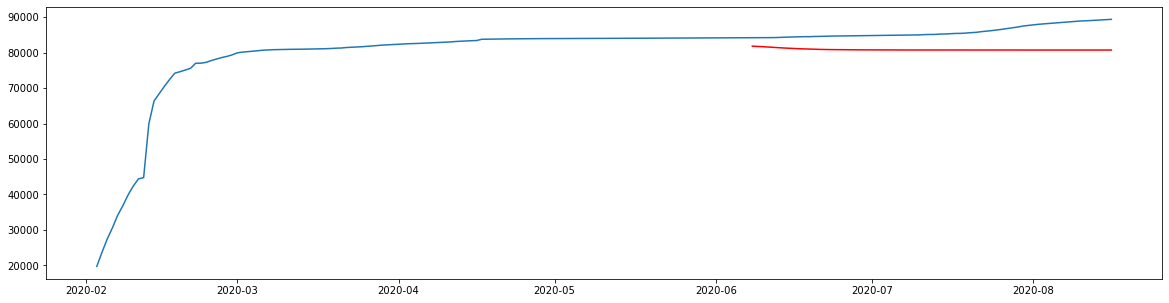

In [107]:
## visulisation
plt.figure(figsize=(20,5))
plt.plot(df_test_c.index,df_test_c["China"])
plt.plot(df_test_c.index,df_test_c["Prediction_China"],color="r")
plt.show()

In [134]:
df_mse_c=df_test_c[-30:]
rmse_c= ((df_mse_c.China - df_mse_c.Prediction_China) ** 2).mean() ** .5
print("Total loss on China prediction is",rmse_c)

Total loss on China prediction is 2395821.0878910623


## For USA

In [118]:
df_us=df.drop("China", axis=1)
df_us = df_us.iloc[-196:,:2]
df_us.head()

,Date,USA
12,2020-02-03,11
13,2020-02-04,11
14,2020-02-05,11
15,2020-02-06,11
16,2020-02-07,11


In [119]:
df_us.Date = pd.to_datetime(df_us.Date)
df_us =df_us.set_index("Date")
## split the train and test data
train_us, test_us = df_us[:-30],df_us[-30:]
## Set the scaler
scaler=MinMaxScaler()
scaler.fit(train_us)
train_us=scaler.transform(train_us)
test_us=scaler.transform(test_us)

n_input = 14
n_features=1

generator =TimeseriesGenerator(train_us,train_us,length=n_input,batch_size=6)

## build LSTM
model = Sequential()
model.add(LSTM(200,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(200,activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

model.fit_generator(generator,epochs=180)

Epoch 1/180
26/26 [==============================] - 0s 13ms/step - loss: 0.0810
Epoch 2/180
26/26 [==============================] - 0s 13ms/step - loss: 0.0266
Epoch 3/180
26/26 [==============================] - 0s 13ms/step - loss: 0.0052
Epoch 4/180
26/26 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 5/180
26/26 [==============================] - 0s 12ms/step - loss: 9.6690e-04
Epoch 6/180
26/26 [==============================] - 0s 14ms/step - loss: 9.2259e-04
Epoch 7/180
26/26 [==============================] - 0s 14ms/step - loss: 0.0015
Epoch 8/180
26/26 [==============================] - 0s 13ms/step - loss: 9.5142e-04
Epoch 9/180
26/26 [==============================] - 0s 14ms/step - loss: 9.1241e-04
Epoch 10/180
26/26 [==============================] - 0s 14ms/step - loss: 9.9420e-04
Epoch 11/180
26/26 [==============================] - 0s 12ms/step - loss: 0.0020
Epoch 12/180
26/26 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch

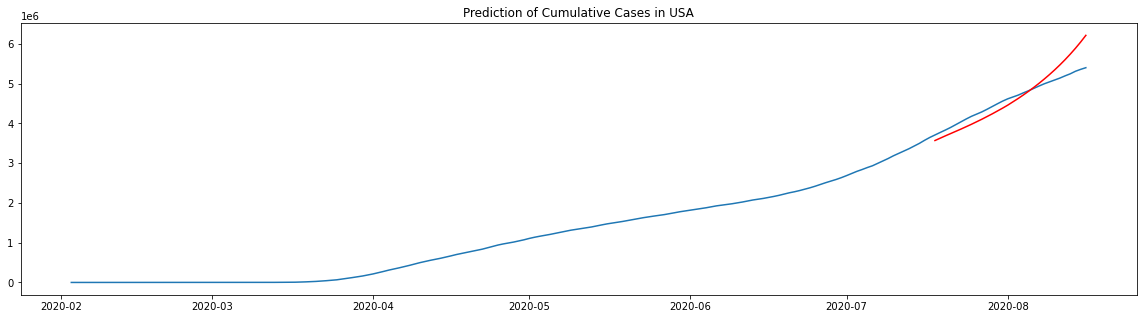

In [120]:
pred_list =[]
batch =train_us[-n_input:].reshape(1,n_input,n_features)

## Do the 70 predictions
for i in range(30):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]],axis=1)

# inverse the scaler (change to the real values), and the make the value to a dataframe
df_predict_us = pd.DataFrame(scaler.inverse_transform(pred_list),index=df_us[-30:].index,columns=["Prediction_USA"])

# concatnate the predicted value with the real values
df_test_us = pd.concat([df_us,df_predict_us], axis=1)

## visulisation
plt.figure(figsize=(20,5))
plt.plot(df_test_us.index,df_test_us["USA"])
plt.plot(df_test_us.index,df_test_us["Prediction_USA"],color="r")
plt.title("Prediction of Cumulative Cases in USA")
plt.show()

In [128]:
df_mse=df_test_us[-30:]
df_mse

,USA,Prediction_USA
Date,,
2020-07-18,3711413,3.570692e+06
2020-07-19,3773260,3.630918e+06
2020-07-20,3834677,3.688112e+06
2020-07-21,3899211,3.744524e+06
2020-07-22,3970121,3.801236e+06
2020-07-23,4038816,3.859006e+06
2020-07-24,4112531,3.918176e+06
2020-07-25,4178970,3.978805e+06
2020-07-26,4233923,4.041255e+06


In [132]:
rmse= ((df_mse.USA - df_mse.Prediction_USA) ** 2).mean() ** .5
print("Total loss on USA prediction is",rmse)

Total loss on USA prediction is 293493.2409698123
